Class
0    284315
1       492
Name: count, dtype: int64


d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch [2/100], Loss: 0.9896
Epoch [4/100], Loss: 0.9887
Epoch [6/100], Loss: 0.9761
Epoch [8/100], Loss: 0.9722
Epoch [10/100], Loss: 0.9708
Epoch [12/100], Loss: 0.9681
Epoch [14/100], Loss: 0.9631
Epoch [16/100], Loss: 0.9560
Epoch [18/100], Loss: 0.9516
Epoch [20/100], Loss: 0.9466
Epoch [22/100], Loss: 0.9381
Epoch [24/100], Loss: 0.9337
Epoch [26/100], Loss: 0.9282
Epoch [28/100], Loss: 0.9252
Epoch [30/100], Loss: 0.9204
Epoch [32/100], Loss: 0.9178
Epoch [34/100], Loss: 0.9107
Epoch [36/100], Loss: 0.9056
Epoch [38/100], Loss: 0.9010
Epoch [40/100], Loss: 0.8981
Epoch [42/100], Loss: 0.9016
Epoch [44/100], Loss: 0.8984
Epoch [46/100], Loss: 0.8970
Epoch [48/100], Loss: 0.8929
Epoch [50/100], Loss: 0.8893
Epoch [52/100], Loss: 0.8869
Epoch [54/100], Loss: 0.8854
Epoch [56/100], Loss: 0.8837
Epoch [58/100], Loss: 0.8820
Epoch [60/100], Loss: 0.8800
Epoch [62/100], Loss: 0.8783
Epoch [64/100], Loss: 0.8772
Epoch [66/100], Loss: 0.8758
Epoch [68/100], Loss: 0.8746
Epoch [70/100], Lo

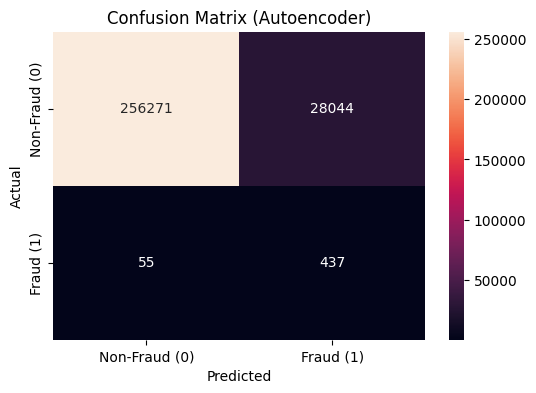

Card Precision@100: 0.3000


In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
##https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud
# Load the dataset
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
# Distribution of the target variable (fraud detection)
status_counts = df.Class.value_counts()
print(status_counts)

#特征转化标准化
# Feature names
features = df.columns[:-1]  # Excluding the target column
# Transforming skewed data
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values



class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            nn.Tanh(),
            nn.Linear(100, 50),
            nn.Tanh(),
            nn.Linear(50, 25),
            nn.Tanh(),
            nn.Linear(25, 12),
            nn.Tanh(),
            nn.Linear(12, 6),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            nn.Tanh(),
            nn.Linear(12, 25),
            nn.Tanh(),
            nn.Linear(25, 50),
            nn.Tanh(),
            nn.Linear(50, 100),
            nn.Tanh(),
            nn.Linear(100, input_dim),
            nn.ReLU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)



# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

def card_precision_at_k(preds, y_true, k=100):
    """
    Calculate Card Precision at K, i.e., the fraction of relevant items
    (fraud samples) in the top K predictions (highest MSE).
    """
    # Get the indices of the top K largest MSE values
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    
    # Check how many of the top K are actual frauds (y_true == 1)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    
    # Calculate precision: number of frauds in top K / K
    return relevant_count / k

# Use the MSE values (reconstruction errors) from the autoencoder
pred_scores = mse  # The MSE values calculated during autoencoder evaluation

# --- Calculate Card Precision@100 ---
card_precision = card_precision_at_k(pred_scores, y, k=100)
print(f"Card Precision@100: {card_precision:.4f}")

Class
0    284315
1       492
Name: count, dtype: int64


d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch [2/100], Loss: 0.9920
Epoch [4/100], Loss: 0.9823
Epoch [6/100], Loss: 0.9491
Epoch [8/100], Loss: 0.9206
Epoch [10/100], Loss: 0.9143
Epoch [12/100], Loss: 0.8934
Epoch [14/100], Loss: 0.8867
Epoch [16/100], Loss: 0.8702
Epoch [18/100], Loss: 0.8693
Epoch [20/100], Loss: 0.8653
Epoch [22/100], Loss: 0.8586
Epoch [24/100], Loss: 0.8577
Epoch [26/100], Loss: 0.8509
Epoch [28/100], Loss: 0.8499
Epoch [30/100], Loss: 0.8466
Epoch [32/100], Loss: 0.8418
Epoch [34/100], Loss: 0.8381
Epoch [36/100], Loss: 0.8329
Epoch [38/100], Loss: 0.8282
Epoch [40/100], Loss: 0.8194
Epoch [42/100], Loss: 0.8063
Epoch [44/100], Loss: 0.8049
Epoch [46/100], Loss: 0.7923
Epoch [48/100], Loss: 0.7947
Epoch [50/100], Loss: 0.7893
Epoch [52/100], Loss: 0.7862
Epoch [54/100], Loss: 0.7792
Epoch [56/100], Loss: 0.7775
Epoch [58/100], Loss: 0.7741
Epoch [60/100], Loss: 0.7726
Epoch [62/100], Loss: 0.7683
Epoch [64/100], Loss: 0.7662
Epoch [66/100], Loss: 0.7629
Epoch [68/100], Loss: 0.7631
Epoch [70/100], Lo

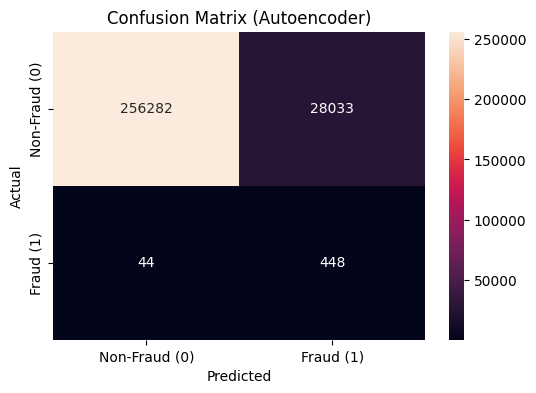

Card Precision@100: 0.3000


In [30]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
##https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud
# Load the dataset
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
# Distribution of the target variable (fraud detection)
status_counts = df.Class.value_counts()
print(status_counts)

#特征转化标准化
# Feature names
features = df.columns[:-1]  # Excluding the target column
# Transforming skewed data
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class GELU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(2.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            GEU(),
            nn.Linear(100, 50),
            GEU(),
            nn.Linear(50, 25),
            GEU(),
            nn.Linear(25, 12),
            GEU(),
            nn.Linear(12, 6),
            GELU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            GEU(),
            nn.Linear(12, 25),
            GEU(),
            nn.Linear(25, 50),
            GEU(),
            nn.Linear(50, 100),
            GEU(),
            nn.Linear(100, input_dim),
            GELU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)



# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

def card_precision_at_k(preds, y_true, k=100):
    """
    Calculate Card Precision at K, i.e., the fraction of relevant items
    (fraud samples) in the top K predictions (highest MSE).
    """
    # Get the indices of the top K largest MSE values
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    
    # Check how many of the top K are actual frauds (y_true == 1)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    
    # Calculate precision: number of frauds in top K / K
    return relevant_count / k

# Use the MSE values (reconstruction errors) from the autoencoder
pred_scores = mse  # The MSE values calculated during autoencoder evaluation

# --- Calculate Card Precision@100 ---
card_precision = card_precision_at_k(pred_scores, y, k=100)
print(f"Card Precision@100: {card_precision:.4f}")

In [31]:
for name, module in autoencoder.named_modules():
    if isinstance(module, GEU):
        print(f"GEU sigma: {module.sigma.item()}")
    elif isinstance(module, GELU):
        print(f"GELU sigma: {module.sigma.item()}")

GEU sigma: 1.333621859550476
GEU sigma: 1.2725517749786377
GEU sigma: 1.2050220966339111
GEU sigma: 1.0556044578552246
GELU sigma: 2.228588342666626
GEU sigma: 0.9395394921302795
GEU sigma: 0.9633104801177979
GEU sigma: 0.978215754032135
GEU sigma: 0.9657608866691589
GELU sigma: 2.8587899208068848


Class
0    284315
1       492
Name: count, dtype: int64


d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch [2/100], Loss: 0.9910
Epoch [4/100], Loss: 0.9834
Epoch [6/100], Loss: 0.9556
Epoch [8/100], Loss: 0.9360
Epoch [10/100], Loss: 0.9210
Epoch [12/100], Loss: 0.9157
Epoch [14/100], Loss: 0.9024
Epoch [16/100], Loss: 0.8921
Epoch [18/100], Loss: 0.8867
Epoch [20/100], Loss: 0.8815
Epoch [22/100], Loss: 0.8756
Epoch [24/100], Loss: 0.8703
Epoch [26/100], Loss: 0.8655
Epoch [28/100], Loss: 0.8604
Epoch [30/100], Loss: 0.8544
Epoch [32/100], Loss: 0.8526
Epoch [34/100], Loss: 0.8423
Epoch [36/100], Loss: 0.8404
Epoch [38/100], Loss: 0.8335
Epoch [40/100], Loss: 0.8289
Epoch [42/100], Loss: 0.8240
Epoch [44/100], Loss: 0.8195
Epoch [46/100], Loss: 0.8186
Epoch [48/100], Loss: 0.8126
Epoch [50/100], Loss: 0.8115
Epoch [52/100], Loss: 0.8055
Epoch [54/100], Loss: 0.8012
Epoch [56/100], Loss: 0.7988
Epoch [58/100], Loss: 0.8029
Epoch [60/100], Loss: 0.8015
Epoch [62/100], Loss: 0.8000
Epoch [64/100], Loss: 0.7935
Epoch [66/100], Loss: 0.7920
Epoch [68/100], Loss: 0.7918
Epoch [70/100], Lo

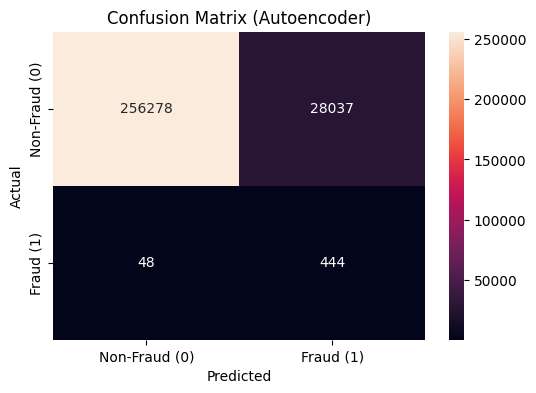

Card Precision@100: 0.3500


In [18]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
##https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud
# Load the dataset
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
# Distribution of the target variable (fraud detection)
status_counts = df.Class.value_counts()
print(status_counts)

#特征转化标准化
# Feature names
features = df.columns[:-1]  # Excluding the target column
# Transforming skewed data
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class GELU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(0.8))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)))) / 2
        return temp

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            GEU(),
            nn.Linear(100, 50),
            GEU(),
            nn.Linear(50, 25),
            GEU(),
            nn.Linear(25, 12),
            GEU(),
            nn.Linear(12, 6),
            GELU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            GEU(),
            nn.Linear(12, 25),
            GEU(),
            nn.Linear(25, 50),
            GEU(),
            nn.Linear(50, 100),
            GEU(),
            nn.Linear(100, input_dim),
            GELU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)



# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

def card_precision_at_k(preds, y_true, k=100):
    """
    Calculate Card Precision at K, i.e., the fraction of relevant items
    (fraud samples) in the top K predictions (highest MSE).
    """
    # Get the indices of the top K largest MSE values
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    
    # Check how many of the top K are actual frauds (y_true == 1)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    
    # Calculate precision: number of frauds in top K / K
    return relevant_count / k

# Use the MSE values (reconstruction errors) from the autoencoder
pred_scores = mse  # The MSE values calculated during autoencoder evaluation

# --- Calculate Card Precision@100 ---
card_precision = card_precision_at_k(pred_scores, y, k=100)
print(f"Card Precision@100: {card_precision:.4f}")

In [19]:
for name, module in autoencoder.named_modules():
    if isinstance(module, GEU):
        print(f"GEU sigma: {module.sigma.item()}")
    elif isinstance(module, GELU):
        print(f"GELU sigma: {module.sigma.item()}")

GEU sigma: 1.1706148386001587
GEU sigma: 1.1732738018035889
GEU sigma: 1.1332759857177734
GEU sigma: 1.0345481634140015
GELU sigma: 0.800000011920929
GEU sigma: 0.9376725554466248
GEU sigma: 0.9801077842712402
GEU sigma: 1.0043418407440186
GEU sigma: 1.0071449279785156
GELU sigma: 0.800000011920929


Class
0    284315
1       492
Name: count, dtype: int64


d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


Epoch [2/100], Loss: 0.9895
Epoch [4/100], Loss: 0.9655
Epoch [6/100], Loss: 0.9352
Epoch [8/100], Loss: 0.9278
Epoch [10/100], Loss: 0.9137
Epoch [12/100], Loss: 0.9118
Epoch [14/100], Loss: 0.9022
Epoch [16/100], Loss: 0.9016
Epoch [18/100], Loss: 0.8969
Epoch [20/100], Loss: 0.8931
Epoch [22/100], Loss: 0.8893
Epoch [24/100], Loss: 0.8843
Epoch [26/100], Loss: 0.8803
Epoch [28/100], Loss: 0.8736
Epoch [30/100], Loss: 0.8650
Epoch [32/100], Loss: 0.8578
Epoch [34/100], Loss: 0.8517
Epoch [36/100], Loss: 0.8460
Epoch [38/100], Loss: 0.8402
Epoch [40/100], Loss: 0.8357
Epoch [42/100], Loss: 0.8340
Epoch [44/100], Loss: 0.8242
Epoch [46/100], Loss: 0.8170
Epoch [48/100], Loss: 0.8126
Epoch [50/100], Loss: 0.8063
Epoch [52/100], Loss: 0.8012
Epoch [54/100], Loss: 0.7940
Epoch [56/100], Loss: 0.7896
Epoch [58/100], Loss: 0.7833
Epoch [60/100], Loss: 0.7809
Epoch [62/100], Loss: 0.7761
Epoch [64/100], Loss: 0.7708
Epoch [66/100], Loss: 0.7665
Epoch [68/100], Loss: 0.7623
Epoch [70/100], Lo

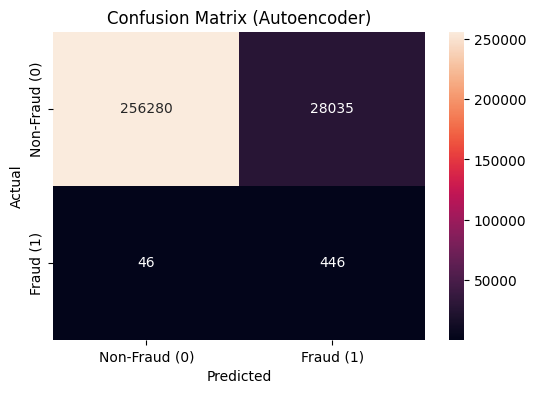

Card Precision@100: 0.3000


In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
##https://www.kaggle.com/code/annastasy/anomaly-detection-credit-card-fraud
# Load the dataset
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")
# Distribution of the target variable (fraud detection)
status_counts = df.Class.value_counts()
print(status_counts)

#特征转化标准化
# Feature names
features = df.columns[:-1]  # Excluding the target column
# Transforming skewed data
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

class GEU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # 计算 GEU 激活函数的输出
        temp = torch.tanh(input / self.sigma)
        return temp

class GELU(nn.Module):  # 激活函数含噪声参数
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(1.0))  # 1个可学习参数 sigma

    def forward(self, input):
        # GELU 激活函数的计算公式
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp

class Autoencoder(nn.Module):
    def __init__(self, input_dim):
        super(Autoencoder, self).__init__()
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            GEU(),
            nn.Linear(100, 50),
            GEU(),
            nn.Linear(50, 25),
            GEU(),
            nn.Linear(25, 12),
            GEU(),
            nn.Linear(12, 6),
            GELU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            GEU(),
            nn.Linear(12, 25),
            GEU(),
            nn.Linear(25, 50),
            GEU(),
            nn.Linear(50, 100),
            GEU(),
            nn.Linear(100, input_dim),
            GELU()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Initialize the model
input_dim = df_transformed.shape[1] - 1  # Excluding target column
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)

# Initialize the model, loss function, and optimizer
autoencoder = Autoencoder(input_dim).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
df_transformed = df.copy()
# Training the Autoencoder
num_epochs = 100
for epoch in range(num_epochs):
    autoencoder.train()
    optimizer.zero_grad()
    
    # Forward pass
    reconstructed = autoencoder(X_train)
    loss = criterion(reconstructed, X_train)
    
    # Backward pass and optimization
    loss.backward()
    optimizer.step()
    
    if (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Calculate reconstruction error
autoencoder.eval()
X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
reconstructed = autoencoder(X_scaled_tensor)
mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

# Set a threshold for anomaly detection
threshold = np.percentile(mse, 90)
autoen_preds = np.where(mse > threshold, 1, 0)

# Autoencoder evaluation
print("Autoencoder Evaluation:")
print(classification_report(y, autoen_preds))
roc_auc = roc_auc_score(y, autoen_preds)
print("ROC AUC Score: ", roc_auc)



# Confusion Matrix
cm = confusion_matrix(y, autoen_preds)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='g')
plt.title('Confusion Matrix (Autoencoder)')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.xticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.yticks([0.5, 1.5], ['Non-Fraud (0)', 'Fraud (1)'])
plt.show()

def card_precision_at_k(preds, y_true, k=100):
    """
    Calculate Card Precision at K, i.e., the fraction of relevant items
    (fraud samples) in the top K predictions (highest MSE).
    """
    # Get the indices of the top K largest MSE values
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    
    # Check how many of the top K are actual frauds (y_true == 1)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    
    # Calculate precision: number of frauds in top K / K
    return relevant_count / k

# Use the MSE values (reconstruction errors) from the autoencoder
pred_scores = mse  # The MSE values calculated during autoencoder evaluation

# --- Calculate Card Precision@100 ---
card_precision = card_precision_at_k(pred_scores, y, k=100)
print(f"Card Precision@100: {card_precision:.4f}")

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")

# Feature transformation and scaling
features = df.columns[:-1]  # Excluding the target column
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

# Define GEU activation function with learnable sigma
class GEU(nn.Module):
    def __init__(self, sigma_init=1.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))  # Learnable parameter sigma

    def forward(self, input):
        temp = torch.tanh(input / self.sigma)
        return temp

# Define GELU activation function with learnable sigma
class GELU(nn.Module):
    def __init__(self, sigma_init=1.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))  # Learnable parameter sigma

    def forward(self, input):
        temp = input * torch.sigmoid(input / self.sigma)
        return temp

# Define the Autoencoder model with GEU and GELU layers
class Autoencoder(nn.Module):
    def __init__(self, input_dim, geu_sigma_list, gelu_sigma_list):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            GEU(sigma_init=geu_sigma_list[0]),  # First GEU layer with specific sigma
            nn.Linear(100, 50),
            GEU(sigma_init=geu_sigma_list[1]),  # Second GEU layer with specific sigma
            nn.Linear(50, 25),
            GEU(sigma_init=geu_sigma_list[2]),  # Third GEU layer with specific sigma
            nn.Linear(25, 12),
            GEU(sigma_init=geu_sigma_list[3]),  # Fourth GEU layer with specific sigma
            nn.Linear(12, 6),
            GELU(sigma_init=gelu_sigma_list[0])  # First GELU layer with specific sigma
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            GEU(sigma_init=geu_sigma_list[4]),  # Fifth GEU layer with specific sigma
            nn.Linear(12, 25),
            GEU(sigma_init=geu_sigma_list[5]),  # Sixth GEU layer with specific sigma
            nn.Linear(25, 50),
            GEU(sigma_init=geu_sigma_list[6]),  # Seventh GEU layer with specific sigma
            nn.Linear(50, 100),
            GEU(sigma_init=geu_sigma_list[7]),  # Eighth GEU layer with specific sigma
            nn.Linear(100, input_dim),
            GELU(sigma_init=gelu_sigma_list[1])  # Second GELU layer with specific sigma
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training data (fraud = 0, non-fraud = 1)
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)
y_train = torch.tensor(y[y == 0], dtype=torch.float32).to(device)

# Define function to compute Card Precision at K
def card_precision_at_k(preds, y_true, k=100):
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    return relevant_count / k

# Define the Optuna objective function
bestobjective_value = -10
def objective(trial):
    global bestobjective_value
    # Suggest sigma values for each layer
    geu_sigma_list = [
        trial.suggest_float('geu_sigma_1', 0.001, 3.0),
        trial.suggest_float('geu_sigma_2', 0.001, 3.0),
        trial.suggest_float('geu_sigma_3', 0.001, 3.0),
        trial.suggest_float('geu_sigma_4', 0.001, 3.0),
        trial.suggest_float('geu_sigma_5', 0.001, 3.0),
        trial.suggest_float('geu_sigma_6', 0.001, 3.0),
        trial.suggest_float('geu_sigma_7', 0.001, 3.0),
        trial.suggest_float('geu_sigma_8', 0.001, 3.0)
    ]
    
    gelu_sigma_list = [
        trial.suggest_float('gelu_sigma_1', 0.001, 3.0),
        trial.suggest_float('gelu_sigma_2', 0.001, 3.0)
    ]

    # Initialize the Autoencoder with the optimized sigma values for each layer
    autoencoder = Autoencoder(input_dim=X_train.shape[1], geu_sigma_list=geu_sigma_list, gelu_sigma_list=gelu_sigma_list).to(device)

    # Initialize optimizer and loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training the Autoencoder
    num_epochs = 100  # Set training epochs to 100 for stability
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = autoencoder(X_train)
        loss = criterion(reconstructed, X_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate reconstruction error (MSE)
    autoencoder.eval()
    X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    reconstructed = autoencoder(X_scaled_tensor)
    mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

    # Set a threshold for anomaly detection
    threshold = np.percentile(mse, 90)
    autoen_preds = np.where(mse > threshold, 1, 0)

    # Autoencoder evaluation (ROC AUC and Card Precision@100)
    auc_score = roc_auc_score(y, autoen_preds)
    
    # Card Precision at 100
    card_precision = card_precision_at_k(mse, y, k=100)

    # Combine metric as the objective (AUC + Card Precision)
    objective_value = auc_score + card_precision  # Adjust weighting if necessary

    if objective_value > bestobjective_value:
        print(auc_score)
        print(card_precision)
        cm = confusion_matrix(y, autoen_preds)
        print(cm)
        bestobjective_value = objective_value
    else:
        pass

   
    return objective_value

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize the objective value
study.optimize(objective, n_trials=100)

# Print the best parameters after optimization
print(f"Best parameters: {study.best_params}")

d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2024-12-20 16:01:37,348] A new study created in memory with name: no-name-fa2d587d-0b53-498b-bb0b-e60ee1c07cdc
[I 2024-12-20 16:01:42,304] Trial 0 finished with value: 1.2129313037225828 and parameters: {'geu_sigma_1': 1.6242672437542964, 'geu_sigma_2': 0.45054035609373966, 'geu_sigma_3': 2.1348765923843516, 'geu_sigma_4': 0.22287612569444157, 'geu_sigma_5': 0.677072876860584, 'geu_sigma_6': 1.1917022984019259, 'geu_sigma_7': 1.4879322301301208, 'geu_sigma_8': 0.8357097415654817, 'gelu_sigma_1': 2.318983409344153, 'gelu_sigma_2': 1.874302258355571}. Best is trial 0 with value: 1.2129313037225828.


0.9029313037225829
0.31
[[256279  28036]
 [    47    445]]


[I 2024-12-20 16:01:47,000] Trial 1 finished with value: 1.1819132849471752 and parameters: {'geu_sigma_1': 2.277437510758879, 'geu_sigma_2': 0.37549352832002436, 'geu_sigma_3': 0.9147199635938428, 'geu_sigma_4': 2.691936906509704, 'geu_sigma_5': 2.785121881948073, 'geu_sigma_6': 1.1605104736121155, 'geu_sigma_7': 0.8940778012909951, 'geu_sigma_8': 1.4045652553062982, 'gelu_sigma_1': 1.872026959262278, 'gelu_sigma_2': 1.3128755946839106}. Best is trial 0 with value: 1.2129313037225828.
[I 2024-12-20 16:01:51,703] Trial 2 finished with value: 1.1639493224979907 and parameters: {'geu_sigma_1': 1.1546843081098943, 'geu_sigma_2': 0.8241293721615736, 'geu_sigma_3': 2.193810420509127, 'geu_sigma_4': 1.963726404381494, 'geu_sigma_5': 1.6859939621623907, 'geu_sigma_6': 2.789205882627791, 'geu_sigma_7': 2.5913846307723674, 'geu_sigma_8': 2.348549714772309, 'gelu_sigma_1': 2.9229284127463417, 'gelu_sigma_2': 0.8140624732205254}. Best is trial 0 with value: 1.2129313037225828.
[I 2024-12-20 16:01

0.8998772473963595
0.42
[[256276  28039]
 [    50    442]]


[I 2024-12-20 16:02:01,189] Trial 4 finished with value: 1.1598772473963597 and parameters: {'geu_sigma_1': 1.4494622875095813, 'geu_sigma_2': 1.0566499300883203, 'geu_sigma_3': 2.441173228897649, 'geu_sigma_4': 1.9554041233185633, 'geu_sigma_5': 2.0141417591613338, 'geu_sigma_6': 1.026802867725332, 'geu_sigma_7': 1.586777140870125, 'geu_sigma_8': 1.3648408967091143, 'gelu_sigma_1': 2.3509016301056938, 'gelu_sigma_2': 2.732562545863685}. Best is trial 3 with value: 1.3198772473963596.
[I 2024-12-20 16:02:05,881] Trial 5 finished with value: 1.1908952661717673 and parameters: {'geu_sigma_1': 0.21992492394324312, 'geu_sigma_2': 0.4698843470721915, 'geu_sigma_3': 1.2143420028989802, 'geu_sigma_4': 0.04326529553292877, 'geu_sigma_5': 1.1237498634451042, 'geu_sigma_6': 1.7996972845047439, 'geu_sigma_7': 0.9051815281946393, 'geu_sigma_8': 1.9130803564929286, 'gelu_sigma_1': 0.6175592807057668, 'gelu_sigma_2': 2.3109134282670274}. Best is trial 3 with value: 1.3198772473963596.
[I 2024-12-20 

0.9039493224979908
0.48
[[256280  28035]
 [    46    446]]


[I 2024-12-20 16:07:50,843] Trial 78 finished with value: 1.2129313037225828 and parameters: {'geu_sigma_1': 2.9603016724085003, 'geu_sigma_2': 0.3054917748130967, 'geu_sigma_3': 2.1227975670618218, 'geu_sigma_4': 0.8738038584952634, 'geu_sigma_5': 0.23321575772929537, 'geu_sigma_6': 0.47570106677304747, 'geu_sigma_7': 1.5400752861086857, 'geu_sigma_8': 0.7168042339187974, 'gelu_sigma_1': 1.8730098348174509, 'gelu_sigma_2': 0.33642625949207}. Best is trial 77 with value: 1.3839493224979909.
[I 2024-12-20 16:07:55,588] Trial 79 finished with value: 1.1566430033160575 and parameters: {'geu_sigma_1': 2.0349285251896423, 'geu_sigma_2': 0.4713241158232938, 'geu_sigma_3': 1.9719102170138443, 'geu_sigma_4': 1.037993778491335, 'geu_sigma_5': 0.27343597707449124, 'geu_sigma_6': 0.8070723815172091, 'geu_sigma_7': 1.623286033071159, 'geu_sigma_8': 0.7444217142684986, 'gelu_sigma_1': 1.7644920001519346, 'gelu_sigma_2': 0.17309241672288644}. Best is trial 77 with value: 1.3839493224979909.
[I 2024-

Best parameters: {'geu_sigma_1': 2.924888145673142, 'geu_sigma_2': 0.2580669670068387, 'geu_sigma_3': 2.066205787737383, 'geu_sigma_4': 0.773075536721691, 'geu_sigma_5': 0.23173989369002948, 'geu_sigma_6': 0.7979503623912398, 'geu_sigma_7': 1.5671469467276278, 'geu_sigma_8': 0.7765045726052944, 'gelu_sigma_1': 1.7707402804302772, 'gelu_sigma_2': 0.0036028922607544613}


In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")

# Feature transformation and scaling
features = df.columns[:-1]  # Excluding the target column
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

# Define GEU activation function with learnable sigma
class GEU(nn.Module):
    def __init__(self, sigma_init=1.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))  # Learnable parameter sigma

    def forward(self, input):
        temp = torch.tanh(input / self.sigma)
        return temp

# Define GELU activation function with learnable sigma
class GELU(nn.Module):
    def __init__(self, sigma_init=1.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))  # Learnable parameter sigma

    def forward(self, input):
        #temp = input * torch.sigmoid(input / self.sigma)
        temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        return temp

# Define the Autoencoder model with GEU and GELU layers
class Autoencoder(nn.Module):
    def __init__(self, input_dim, geu_sigma_list, gelu_sigma_list):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            GEU(sigma_init=geu_sigma_list[0]),  # First GEU layer with specific sigma
            nn.Linear(100, 50),
            GEU(sigma_init=geu_sigma_list[1]),  # Second GEU layer with specific sigma
            nn.Linear(50, 25),
            GEU(sigma_init=geu_sigma_list[2]),  # Third GEU layer with specific sigma
            nn.Linear(25, 12),
            GEU(sigma_init=geu_sigma_list[3]),  # Fourth GEU layer with specific sigma
            nn.Linear(12, 6),
            GELU(sigma_init=gelu_sigma_list[0])  # First GELU layer with specific sigma
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            GEU(sigma_init=geu_sigma_list[4]),  # Fifth GEU layer with specific sigma
            nn.Linear(12, 25),
            GEU(sigma_init=geu_sigma_list[5]),  # Sixth GEU layer with specific sigma
            nn.Linear(25, 50),
            GEU(sigma_init=geu_sigma_list[6]),  # Seventh GEU layer with specific sigma
            nn.Linear(50, 100),
            GEU(sigma_init=geu_sigma_list[7]),  # Eighth GEU layer with specific sigma
            nn.Linear(100, input_dim),
            GELU(sigma_init=gelu_sigma_list[1])  # Second GELU layer with specific sigma
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training data (fraud = 0, non-fraud = 1)
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)
y_train = torch.tensor(y[y == 0], dtype=torch.float32).to(device)

# Define function to compute Card Precision at K
def card_precision_at_k(preds, y_true, k=100):
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    return relevant_count / k

# Define the Optuna objective function
bestobjective_value = -10
def objective(trial):
    global bestobjective_value
    # Suggest sigma values for each layer
    geu_sigma_list = [
        trial.suggest_float('geu_sigma_1', 0.001, 3.0),
        trial.suggest_float('geu_sigma_2', 0.001, 3.0),
        trial.suggest_float('geu_sigma_3', 0.001, 3.0),
        trial.suggest_float('geu_sigma_4', 0.001, 3.0),
        trial.suggest_float('geu_sigma_5', 0.001, 3.0),
        trial.suggest_float('geu_sigma_6', 0.001, 3.0),
        trial.suggest_float('geu_sigma_7', 0.001, 3.0),
        trial.suggest_float('geu_sigma_8', 0.001, 3.0)
    ]
    
    gelu_sigma_list = [
        trial.suggest_float('gelu_sigma_1', 0.001, 3.0),
        trial.suggest_float('gelu_sigma_2', 0.001, 3.0)
    ]

    # Initialize the Autoencoder with the optimized sigma values for each layer
    autoencoder = Autoencoder(input_dim=X_train.shape[1], geu_sigma_list=geu_sigma_list, gelu_sigma_list=gelu_sigma_list).to(device)

    # Initialize optimizer and loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training the Autoencoder
    num_epochs = 100  # Set training epochs to 100 for stability
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = autoencoder(X_train)
        loss = criterion(reconstructed, X_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate reconstruction error (MSE)
    autoencoder.eval()
    X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    reconstructed = autoencoder(X_scaled_tensor)
    mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

    # Set a threshold for anomaly detection
    threshold = np.percentile(mse, 90)
    autoen_preds = np.where(mse > threshold, 1, 0)

    # Autoencoder evaluation (ROC AUC and Card Precision@100)
    auc_score = roc_auc_score(y, autoen_preds)
    
    # Card Precision at 100
    card_precision = card_precision_at_k(mse, y, k=100)

    # Combine metric as the objective (AUC + Card Precision)
    objective_value = auc_score + card_precision  # Adjust weighting if necessary

    if objective_value > bestobjective_value:
        print(auc_score)
        print(card_precision)
        cm = confusion_matrix(y, autoen_preds)
        print(cm)
        bestobjective_value = objective_value
    else:
        pass

   
    return objective_value

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize the objective value
study.optimize(objective, n_trials=100)

# Print the best parameters after optimization
print(f"Best parameters: {study.best_params}")

d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2024-12-20 16:11:31,499] A new study created in memory with name: no-name-916028cd-30a6-4f1b-a5db-1717fd0d126e
[I 2024-12-20 16:11:36,750] Trial 0 finished with value: 1.162933062335389 and parameters: {'geu_sigma_1': 1.7229667136918738, 'geu_sigma_2': 1.6006523130916153, 'geu_sigma_3': 2.716366847944758, 'geu_sigma_4': 0.7574798229550822, 'geu_sigma_5': 1.7777502687307836, 'geu_sigma_6': 1.7313409343394042, 'geu_sigma_7': 0.2990112131638764, 'geu_sigma_8': 0.1719914493992464, 'gelu_sigma_1': 2.7739295861180064, 'gelu_sigma_2': 0.07555213189966496}. Best is trial 0 with value: 1.162933062335389.


0.9029330623353891
0.26
[[256280  28035]
 [    47    445]]


[I 2024-12-20 16:11:41,734] Trial 1 finished with value: 1.1919132849471752 and parameters: {'geu_sigma_1': 1.5000078237233074, 'geu_sigma_2': 0.7988854639121722, 'geu_sigma_3': 1.2051166220252194, 'geu_sigma_4': 0.5097851123787711, 'geu_sigma_5': 0.5745080340418953, 'geu_sigma_6': 1.2105992458521393, 'geu_sigma_7': 1.3418578975500675, 'geu_sigma_8': 2.38887768176369, 'gelu_sigma_1': 2.1917953688144864, 'gelu_sigma_2': 1.8834361923743057}. Best is trial 1 with value: 1.1919132849471752.


0.9019132849471752
0.29
[[256278  28037]
 [    48    444]]


[I 2024-12-20 16:11:46,625] Trial 2 finished with value: 1.1637691347439123 and parameters: {'geu_sigma_1': 0.9895978440501088, 'geu_sigma_2': 1.8652408364585333, 'geu_sigma_3': 0.07432733680109978, 'geu_sigma_4': 0.03860839200369413, 'geu_sigma_5': 1.693610675105198, 'geu_sigma_6': 2.3158946004920735, 'geu_sigma_7': 1.9212444482871693, 'geu_sigma_8': 0.34780979143150587, 'gelu_sigma_1': 2.9409276398166364, 'gelu_sigma_2': 0.9108028774514264}. Best is trial 1 with value: 1.1919132849471752.
[I 2024-12-20 16:11:51,515] Trial 3 finished with value: 1.1527511159685044 and parameters: {'geu_sigma_1': 2.7492919661525557, 'geu_sigma_2': 1.3969876682404732, 'geu_sigma_3': 2.1858698260030125, 'geu_sigma_4': 0.8514006578794598, 'geu_sigma_5': 1.8294893749779564, 'geu_sigma_6': 0.38758444469211606, 'geu_sigma_7': 2.547151761454821, 'geu_sigma_8': 0.5056710426812338, 'gelu_sigma_1': 0.7805828800180915, 'gelu_sigma_2': 0.2237094343259841}. Best is trial 1 with value: 1.1919132849471752.
[I 2024-12

0.9019132849471752
0.39
[[256278  28037]
 [    48    444]]


[I 2024-12-20 16:12:01,347] Trial 5 finished with value: 1.162931303722583 and parameters: {'geu_sigma_1': 1.4496279819608016, 'geu_sigma_2': 2.7266245732726877, 'geu_sigma_3': 1.9380769365555808, 'geu_sigma_4': 0.9271806477897255, 'geu_sigma_5': 1.880607755753941, 'geu_sigma_6': 0.5387431158027873, 'geu_sigma_7': 2.2178893562369475, 'geu_sigma_8': 0.012196973716863912, 'gelu_sigma_1': 0.7205745194053829, 'gelu_sigma_2': 0.8580791997042985}. Best is trial 4 with value: 1.2919132849471753.
[I 2024-12-20 16:12:06,243] Trial 6 finished with value: 1.2119132849471752 and parameters: {'geu_sigma_1': 2.5622704400939904, 'geu_sigma_2': 0.9670202581726572, 'geu_sigma_3': 1.2914884183604316, 'geu_sigma_4': 1.8776595940799572, 'geu_sigma_5': 2.787597916320847, 'geu_sigma_6': 2.1777608420408034, 'geu_sigma_7': 0.12096216312407589, 'geu_sigma_8': 0.37523174492618266, 'gelu_sigma_1': 2.0134849725209736, 'gelu_sigma_2': 0.23681192375869636}. Best is trial 4 with value: 1.2919132849471753.
[I 2024-12

0.9039493224979908
0.39
[[256280  28035]
 [    46    446]]


[I 2024-12-20 16:16:04,203] Trial 54 finished with value: 1.198679040866873 and parameters: {'geu_sigma_1': 2.896272778714957, 'geu_sigma_2': 1.8635234094782565, 'geu_sigma_3': 0.671617097880284, 'geu_sigma_4': 2.271010058396249, 'geu_sigma_5': 1.5067194638442405, 'geu_sigma_6': 1.3243305460480244, 'geu_sigma_7': 1.4868323951323892, 'geu_sigma_8': 0.5743833577075331, 'gelu_sigma_1': 1.9164861852344515, 'gelu_sigma_2': 0.3006337988249328}. Best is trial 53 with value: 1.2939493224979908.
[I 2024-12-20 16:16:09,144] Trial 55 finished with value: 1.1729313037225828 and parameters: {'geu_sigma_1': 0.8990208599744793, 'geu_sigma_2': 1.7818121576397292, 'geu_sigma_3': 0.10325782037791587, 'geu_sigma_4': 1.9909111516823086, 'geu_sigma_5': 1.4608501363083577, 'geu_sigma_6': 1.186733577532084, 'geu_sigma_7': 1.335075867960393, 'geu_sigma_8': 0.6060540821518179, 'gelu_sigma_1': 2.1868027257792653, 'gelu_sigma_2': 0.7768588944146114}. Best is trial 53 with value: 1.2939493224979908.
[I 2024-12-20

Best parameters: {'geu_sigma_1': 2.839839568821412, 'geu_sigma_2': 1.8273804112005245, 'geu_sigma_3': 0.10823475927018555, 'geu_sigma_4': 1.8402168357435045, 'geu_sigma_5': 1.4708646341276685, 'geu_sigma_6': 2.758426912696962, 'geu_sigma_7': 1.3024308203953545, 'geu_sigma_8': 0.624272648840567, 'gelu_sigma_1': 2.0526026454204036, 'gelu_sigma_2': 0.6209380554869828}


In [56]:
class RayLU(nn.Module):  # 激活函数含噪声参数
    def __init__(self,sigma):
        super().__init__()
        self.sigma = sigma

    def forward(self, input):
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp

In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import optuna
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Load data
df = pd.read_csv("D:/Credit Card Fraud Detection/creditcard.csv")

# Feature transformation and scaling
features = df.columns[:-1]  # Excluding the target column
def log_transform_skewed(column):
    transformed = np.where(column >= 0, np.log1p(column), -np.log1p(-column))
    return transformed

# Log transform skewed features
df_transformed = df.copy()
for col in features:
    if abs(df[col].skew()) > 0.75:  # Threshold for skewness
        df_transformed[col] = log_transform_skewed(df[col])

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_transformed[features])
y = df_transformed.Class.values

# Define GEU activation function with learnable sigma
class GEU(nn.Module):
    def __init__(self, sigma_init=1.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))  # Learnable parameter sigma

    def forward(self, input):
        temp = torch.tanh(input / self.sigma)
        return temp

# Define GELU activation function with learnable sigma
class GELU(nn.Module):
    def __init__(self, sigma_init=1.0):
        super().__init__()
        self.sigma = nn.Parameter(torch.tensor(sigma_init))  # Learnable parameter sigma

    def forward(self, input):
        #temp = input * torch.sigmoid(input / self.sigma)
        #temp = input * (1 + torch.erf(input / torch.sqrt(torch.tensor(2.0)) / self.sigma)) / 2
        temp = torch.where(input >= 0, input, input * torch.exp(-input**2 / (2 * self.sigma**2)))
        return temp

# Define the Autoencoder model with GEU and GELU layers
class Autoencoder(nn.Module):
    def __init__(self, input_dim, geu_sigma_list, gelu_sigma_list):
        super(Autoencoder, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 100),
            GEU(sigma_init=geu_sigma_list[0]),  # First GEU layer with specific sigma
            nn.Linear(100, 50),
            GEU(sigma_init=geu_sigma_list[1]),  # Second GEU layer with specific sigma
            nn.Linear(50, 25),
            GEU(sigma_init=geu_sigma_list[2]),  # Third GEU layer with specific sigma
            nn.Linear(25, 12),
            GEU(sigma_init=geu_sigma_list[3]),  # Fourth GEU layer with specific sigma
            nn.Linear(12, 6),
            GELU(sigma_init=gelu_sigma_list[0])  # First GELU layer with specific sigma
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(6, 12),
            GEU(sigma_init=geu_sigma_list[4]),  # Fifth GEU layer with specific sigma
            nn.Linear(12, 25),
            GEU(sigma_init=geu_sigma_list[5]),  # Sixth GEU layer with specific sigma
            nn.Linear(25, 50),
            GEU(sigma_init=geu_sigma_list[6]),  # Seventh GEU layer with specific sigma
            nn.Linear(50, 100),
            GEU(sigma_init=geu_sigma_list[7]),  # Eighth GEU layer with specific sigma
            nn.Linear(100, input_dim),
            GELU(sigma_init=gelu_sigma_list[1])  # Second GELU layer with specific sigma
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Training data (fraud = 0, non-fraud = 1)
X_train = torch.tensor(X_scaled[y == 0], dtype=torch.float32).to(device)
y_train = torch.tensor(y[y == 0], dtype=torch.float32).to(device)

# Define function to compute Card Precision at K
def card_precision_at_k(preds, y_true, k=100):
    top_k_indices = np.argsort(preds)[-k:]  # Indices of the top K MSE values (highest reconstruction errors)
    relevant_count = np.sum(y_true[top_k_indices] == 1)  # Count how many of the top K are frauds
    return relevant_count / k

# Define the Optuna objective function
bestobjective_value = -10
def objective(trial):
    global bestobjective_value
    # Suggest sigma values for each layer
    geu_sigma_list = [
        trial.suggest_float('geu_sigma_1', 0.001, 3.0),
        trial.suggest_float('geu_sigma_2', 0.001, 3.0),
        trial.suggest_float('geu_sigma_3', 0.001, 3.0),
        trial.suggest_float('geu_sigma_4', 0.001, 3.0),
        trial.suggest_float('geu_sigma_5', 0.001, 3.0),
        trial.suggest_float('geu_sigma_6', 0.001, 3.0),
        trial.suggest_float('geu_sigma_7', 0.001, 3.0),
        trial.suggest_float('geu_sigma_8', 0.001, 3.0)
    ]
    
    gelu_sigma_list = [
        trial.suggest_float('gelu_sigma_1', 0.001, 3.0),
        trial.suggest_float('gelu_sigma_2', 0.001, 3.0)
    ]

    # Initialize the Autoencoder with the optimized sigma values for each layer
    autoencoder = Autoencoder(input_dim=X_train.shape[1], geu_sigma_list=geu_sigma_list, gelu_sigma_list=gelu_sigma_list).to(device)

    # Initialize optimizer and loss function
    optimizer = optim.Adam(autoencoder.parameters(), lr=0.01)
    criterion = nn.MSELoss()

    # Training the Autoencoder
    num_epochs = 100  # Set training epochs to 100 for stability
    for epoch in range(num_epochs):
        autoencoder.train()
        optimizer.zero_grad()
        
        # Forward pass
        reconstructed = autoencoder(X_train)
        loss = criterion(reconstructed, X_train)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()

    # Calculate reconstruction error (MSE)
    autoencoder.eval()
    X_scaled_tensor = torch.tensor(X_scaled, dtype=torch.float32).to(device)
    reconstructed = autoencoder(X_scaled_tensor)
    mse = torch.mean((X_scaled_tensor - reconstructed) ** 2, dim=1).cpu().detach().numpy()

    # Set a threshold for anomaly detection
    threshold = np.percentile(mse, 90)
    autoen_preds = np.where(mse > threshold, 1, 0)

    # Autoencoder evaluation (ROC AUC and Card Precision@100)
    auc_score = roc_auc_score(y, autoen_preds)
    
    # Card Precision at 100
    card_precision = card_precision_at_k(mse, y, k=100)

    # Combine metric as the objective (AUC + Card Precision)
    objective_value = auc_score + card_precision  # Adjust weighting if necessary

    if objective_value > bestobjective_value:
        print(auc_score)
        print(card_precision)
        cm = confusion_matrix(y, autoen_preds)
        print(cm)
        bestobjective_value = objective_value
    else:
        pass

   
    return objective_value

# Create an Optuna study
study = optuna.create_study(direction='maximize')  # Maximize the objective value
study.optimize(objective, n_trials=100)

# Print the best parameters after optimization
print(f"Best parameters: {study.best_params}")

d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
d:\anaconda\envs\torch2\lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)
[I 2024-12-20 16:35:24,149] A new study created in memory with name: no-name-d65b057c-c09a-48bf-80c4-d9bc5d87fdb0
[I 2024-12-20 16:35:29,517] Trial 0 finished with value: 1.1747871535193202 and parameters: {'geu_sigma_1': 0.3654647481688756, 'geu_sigma_2': 2.445741187556768, 'geu_sigma_3': 0.8916278888943479, 'geu_sigma_4': 2.246131321740318, 'geu_sigma_5': 1.2046140954382405, 'geu_sigma_6': 1.6292924158070594, 'geu_sigma_7': 1.1943855111089405, 'geu_sigma_8': 1.9895658815631063, 'gelu_sigma_1': 1.1354119390003883, 'gelu_sigma_2': 1.0063868962945786}. Best is trial 0 with value: 1.1747871535193202.


0.8947871535193203
0.28
[[256271  28044]
 [    55    437]]


[I 2024-12-20 16:35:34,605] Trial 1 finished with value: 1.2117330971930966 and parameters: {'geu_sigma_1': 0.5359171703165883, 'geu_sigma_2': 0.26398639880849073, 'geu_sigma_3': 1.0669242078439287, 'geu_sigma_4': 0.8904108892537954, 'geu_sigma_5': 2.252331496564629, 'geu_sigma_6': 0.4116720711740091, 'geu_sigma_7': 0.2727451311906711, 'geu_sigma_8': 2.589584723143948, 'gelu_sigma_1': 1.2161161118997257, 'gelu_sigma_2': 1.5130122861531643}. Best is trial 1 with value: 1.2117330971930966.


0.8917330971930967
0.32
[[256268  28047]
 [    58    434]]


[I 2024-12-20 16:35:39,621] Trial 2 finished with value: 1.1356249845406494 and parameters: {'geu_sigma_1': 2.4995220888427103, 'geu_sigma_2': 0.24388515754333565, 'geu_sigma_3': 2.6880791673835387, 'geu_sigma_4': 0.8035055857969984, 'geu_sigma_5': 0.6343174011247648, 'geu_sigma_6': 0.9034386619733019, 'geu_sigma_7': 0.3173090103717069, 'geu_sigma_8': 1.2673804601150118, 'gelu_sigma_1': 2.80144495773823, 'gelu_sigma_2': 2.1075422865577136}. Best is trial 1 with value: 1.2117330971930966.
[I 2024-12-20 16:35:44,578] Trial 3 finished with value: 1.1598772473963597 and parameters: {'geu_sigma_1': 2.9551868909346317, 'geu_sigma_2': 0.5763675368272992, 'geu_sigma_3': 2.684549946521193, 'geu_sigma_4': 0.7446029338016528, 'geu_sigma_5': 1.5832762714695776, 'geu_sigma_6': 1.0488700626508844, 'geu_sigma_7': 2.343429240544588, 'geu_sigma_8': 1.9609856310337463, 'gelu_sigma_1': 0.06350865244408335, 'gelu_sigma_2': 1.8422953119052352}. Best is trial 1 with value: 1.2117330971930966.
[I 2024-12-20 

0.8907150784176889
0.35
[[256267  28048]
 [    59    433]]


[I 2024-12-20 16:36:09,656] Trial 8 finished with value: 1.162933062335389 and parameters: {'geu_sigma_1': 1.369335482943222, 'geu_sigma_2': 2.5303733478269224, 'geu_sigma_3': 2.0676770169464005, 'geu_sigma_4': 0.7948741749499947, 'geu_sigma_5': 2.482029466266385, 'geu_sigma_6': 2.497942920896507, 'geu_sigma_7': 2.379100887333115, 'geu_sigma_8': 0.338230335717861, 'gelu_sigma_1': 0.618118588008004, 'gelu_sigma_2': 0.08102604603149768}. Best is trial 7 with value: 1.240715078417689.
[I 2024-12-20 16:36:14,655] Trial 9 finished with value: 1.1798772473963597 and parameters: {'geu_sigma_1': 0.7531158067641027, 'geu_sigma_2': 2.2305119903445725, 'geu_sigma_3': 1.3634182916230086, 'geu_sigma_4': 1.1167312759528354, 'geu_sigma_5': 0.7037943193637642, 'geu_sigma_6': 2.062273369474072, 'geu_sigma_7': 0.4542366969738105, 'geu_sigma_8': 1.4774485225525515, 'gelu_sigma_1': 1.6392202470683037, 'gelu_sigma_2': 1.3832388072992465}. Best is trial 7 with value: 1.240715078417689.
[I 2024-12-20 16:36:1

0.8917330971930967
0.35
[[256268  28047]
 [    58    434]]


[I 2024-12-20 16:37:10,109] Trial 20 finished with value: 1.1798772473963597 and parameters: {'geu_sigma_1': 1.0532619778740342, 'geu_sigma_2': 0.8415270811566385, 'geu_sigma_3': 1.7059192079843086, 'geu_sigma_4': 1.9784233045817834, 'geu_sigma_5': 0.41674133162316046, 'geu_sigma_6': 1.644882452605851, 'geu_sigma_7': 2.0472258963649708, 'geu_sigma_8': 1.0295712031006268, 'gelu_sigma_1': 2.583884718473187, 'gelu_sigma_2': 1.365458402074374}. Best is trial 19 with value: 1.2417330971930967.
[I 2024-12-20 16:37:15,171] Trial 21 finished with value: 1.1839493224979907 and parameters: {'geu_sigma_1': 0.2702478551263532, 'geu_sigma_2': 1.1889221599050934, 'geu_sigma_3': 1.571380826260604, 'geu_sigma_4': 0.5452028073652719, 'geu_sigma_5': 0.37043584699118354, 'geu_sigma_6': 1.7927126616937565, 'geu_sigma_7': 1.3799423442779308, 'geu_sigma_8': 0.22837899104855217, 'gelu_sigma_1': 2.633189535700926, 'gelu_sigma_2': 0.7494929394301793}. Best is trial 19 with value: 1.2417330971930967.
[I 2024-12

0.8907150784176889
0.36
[[256267  28048]
 [    59    433]]


[I 2024-12-20 16:40:32,160] Trial 60 finished with value: 1.1608952661717673 and parameters: {'geu_sigma_1': 1.627673326753243, 'geu_sigma_2': 0.666437430196326, 'geu_sigma_3': 0.37009973988482314, 'geu_sigma_4': 0.009541755236548592, 'geu_sigma_5': 0.8332199161726227, 'geu_sigma_6': 1.8983532125998765, 'geu_sigma_7': 1.588750042081254, 'geu_sigma_8': 2.26691347156356, 'gelu_sigma_1': 1.7212167987727338, 'gelu_sigma_2': 0.802816138811312}. Best is trial 59 with value: 1.2507150784176888.
[I 2024-12-20 16:40:37,187] Trial 61 finished with value: 1.2476610220914655 and parameters: {'geu_sigma_1': 1.3694104728247738, 'geu_sigma_2': 0.14638655871748518, 'geu_sigma_3': 0.21244188967775482, 'geu_sigma_4': 0.12094865969151769, 'geu_sigma_5': 1.0044381857746911, 'geu_sigma_6': 1.6886941699055333, 'geu_sigma_7': 0.11177987935109127, 'geu_sigma_8': 2.512061431502976, 'gelu_sigma_1': 1.8470760712102217, 'gelu_sigma_2': 0.9129524194531029}. Best is trial 59 with value: 1.2507150784176888.
[I 2024-

0.8927511159685045
0.4
[[256269  28046]
 [    57    435]]


[I 2024-12-20 16:43:23,797] Trial 94 finished with value: 1.215805172294728 and parameters: {'geu_sigma_1': 0.44977165751665316, 'geu_sigma_2': 0.14905923292436518, 'geu_sigma_3': 0.1910643962365644, 'geu_sigma_4': 0.13904949248316287, 'geu_sigma_5': 0.12105721983738332, 'geu_sigma_6': 2.9182212188421772, 'geu_sigma_7': 0.39992244155420376, 'geu_sigma_8': 1.4244037048994738, 'gelu_sigma_1': 2.4463414120578237, 'gelu_sigma_2': 0.20054378784074153}. Best is trial 93 with value: 1.2927511159685046.
[I 2024-12-20 16:43:28,901] Trial 95 finished with value: 1.2227511159685045 and parameters: {'geu_sigma_1': 0.18533307462071325, 'geu_sigma_2': 0.3659826095578537, 'geu_sigma_3': 0.074624030912178, 'geu_sigma_4': 0.47637520409978973, 'geu_sigma_5': 0.3601187607875904, 'geu_sigma_6': 1.6784815618773847, 'geu_sigma_7': 0.32586583642231337, 'geu_sigma_8': 1.2471063617272642, 'gelu_sigma_1': 2.073752737150248, 'gelu_sigma_2': 0.5923524481737527}. Best is trial 93 with value: 1.2927511159685046.
[I

Best parameters: {'geu_sigma_1': 1.008559918656899, 'geu_sigma_2': 0.06750299591828746, 'geu_sigma_3': 0.18030222548805697, 'geu_sigma_4': 0.20096052342396653, 'geu_sigma_5': 0.10052170106681357, 'geu_sigma_6': 1.4061993108770445, 'geu_sigma_7': 0.07739808966116085, 'geu_sigma_8': 1.4279759819064939, 'gelu_sigma_1': 2.074382517629931, 'gelu_sigma_2': 0.7809638969701274}
